In [5]:
import mailbox
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from underthesea import word_tokenize
from bs4 import BeautifulSoup
from email.header import decode_header
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from collections import Counter

In [6]:
# # Ghép nhiều file lại với nhau

# mbox_files = ['data1.mbox', 'data2.mbox'] # tải file takeout của gg về giải nén ra rồi đổi tên hoặc 
# output_file = 'data.mbox'
# merged_mbox = mailbox.mbox(output_file)
# for mbox_file in mbox_files:
#     current_mbox = mailbox.mbox(mbox_file)
    

#     for message in current_mbox:
#         merged_mbox.add(message)
# merged_mbox.flush()
# merged_mbox.close()

# print(f"File '{output_file}' đã được tạo thành công với tất cả các thư từ các file mbox đã cho.")


In [7]:

# === Load stopwords ===
def load_words(file_path):
    with open(file_path, encoding='utf-8') as f:
        return set(line.strip().lower() for line in f if line.strip())

stopwords = load_words('vietnamese-stopwords.txt')

# === Load spamwords  ===
def load_spamwords(file_path):
    spamwords = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if '|' in line:
                word, score = line.strip().split('|')
                spamwords[word.lower()] = int(score)
    return spamwords

spamwords = load_spamwords('spamword.txt')

# === Giải mã tiêu đề ===
def decode_mime_words(s):
    if not s:
        return ''
    decoded_parts = decode_header(s)
    result = ''
    for part, enc in decoded_parts:
        if isinstance(part, bytes):
            try:
                result += part.decode(enc or 'utf-8', errors='ignore')
            except LookupError:
                result += part.decode('utf-8', errors='ignore')
        else:
            result += part
    return result

# === Làm sạch nội dung text ===
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[\n\r\t]+', ' ', text)
    text = re.sub(r'[^\w\sÀ-ỹ]', '', text)
    words = text.lower().split()
    filtered = [w for w in words if w not in stopwords]
    return ' '.join(filtered)

# === Tính tổng điểm spam ===
def calculate_spam_score(text):
    score = 0
    text_lower = text.lower()
    for word, word_score in spamwords.items():
        if word in text_lower:
            score += word_score
    return score




In [8]:
# === Đọc email từ file mbox ===
def extract_emails(mbox_file):
    data = []
    for message in mailbox.mbox(mbox_file):
        subject = decode_mime_words(message['subject'])
        subject_clean = clean_text(subject)

        body = ''
        if message.is_multipart():
            for part in message.walk():
                if part.get_content_type() == 'text/plain':
                    try:
                        body = part.get_payload(decode=True).decode(part.get_content_charset() or 'utf-8', errors='ignore')
                        break
                    except:
                        pass
        else:
            try:
                body = message.get_payload(decode=True).decode(message.get_content_charset() or 'utf-8', errors='ignore')
            except:
                pass

        body_clean = clean_text(body)
        full_text = subject_clean + ' ' + body_clean
        spam_score = calculate_spam_score(full_text)
        is_spam = 1 if spam_score >= 10 else 0
        data.append((is_spam, full_text))

    # Lưu file CSV
    with open('output.csv', 'w', encoding='utf-8', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['label', 'email_content'])
        writer.writerows(data)

    return data


In [9]:
# === Huấn luyện Logistic Regression ===
def train_model(data):
    labels, texts = zip(*data)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Calculate spam counts
    num_spam_test = sum(y_test)
    num_spam_pred = sum(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    true_spam = cm[1, 1] 

    print("\n===== ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION =====")
    print(f"Tổng số email xử lý: {len(data)}")
    print(f"Số mẫu training     : {len(y_train)}")
    print(f"Số mẫu test         : {len(y_test)}")
    print(f"Số lượng thư spam thực tế trong tập test: {num_spam_test}")
    print(f"Số lượng thư được dự đoán là spam trong tập test: {num_spam_pred}")
    print(f"Số lượng thư spam được dự đoán đúng: {true_spam}")
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    print(classification_report(y_test, y_pred, target_names=["Not Spam", "Spam"]))

In [10]:
def K_mean():

    df = pd.read_csv('output.csv')
    email_texts_raw = df['email_content'].astype(str).tolist()

    # add Dictionary
    with open('English_and_Vietnamese_lib.txt', 'r', encoding='utf-8') as f:
        allowed_words = set(line.strip().lower() for line in f if line.strip())

    # Clean and filter word by dictionary
    def preprocess_with_dictionary(text, dictionary):
        text = re.sub(r'[^\w\s]', ' ', text)      # delete punctuation
        text = re.sub(r'\s+', ' ', text)          # delete space
        text = text.lower()
        tokens = word_tokenize(text)              # split words
        filtered_tokens = [word for word in tokens if word in dictionary and word.isalpha()]
        return ' '.join(filtered_tokens)

    # Clean text 
    cleaned_texts = [preprocess_with_dictionary(text, allowed_words) for text in email_texts_raw]

    # Vectorlize TF-IDF 
    vectorizer = TfidfVectorizer(
        max_df=0.7,
        min_df=10,
    )

    X_tfidf = vectorizer.fit_transform(cleaned_texts)

    # Check words
    print("Số văn bản:", X_tfidf.shape[0])
    print("Số từ sau lọc và vector hóa:", X_tfidf.shape[1])
    print("Một số từ đặc trưng:", vectorizer.get_feature_names_out()[:1000])


    all_words = ' '.join(cleaned_texts).split()

    # count words appear in all emails
    word_counter = Counter(all_words)
    word_list = list(word_counter.keys())
    word_counts = list(word_counter.values())

    paired = sorted(zip(word_counts,word_list))  # arrange 
    sorted_word_counts ,sorted_word_list  = zip(*paired)

    # change to list
    sorted_word_list = list(sorted_word_list)
    sorted_word_counts = list(sorted_word_counts)


    def get_random_K(arr1, K):
        random_values = []  # Khởi tạo danh sách rỗng để lưu giá trị ngẫu nhiên
        for _ in range(K):
            random_value = np.random.uniform(np.min(arr1), np.max(arr1))
            random_values.append(random_value)  # Thêm vào danh sách
        
        result = np.array(random_values)  # Chuyển sang mảng NumPy và sắp xếp
        return result

    def get_distance(x,y,a,b):
        return np.sqrt(( x - a )**2 + ( y - b )**2)

    def arrange_spot(arrx, arry, point_x, poiny_y):
        K_point_list = []
        for i in range(len(arrx)): 
            temp = []   
            for j in range(len(point_x)):
                distance = get_distance(arrx[i], arry[i], point_x[j], poiny_y[j])
                distance = round(distance,2)
                temp.append(distance)
            min_index = int(np.argmin(temp))
            K_point_list.append(min_index)
        print()
        return K_point_list 


    Xdata = list(range(1, len(sorted_word_list) + 1))
    Ydata = sorted_word_counts
    print(Ydata)
    accuracy = 0
    while(accuracy<0.85):
        X = get_random_K(Xdata,2)
        Y = get_random_K(Ydata,2)

        a =  arrange_spot(Xdata, Ydata, X, Y)
        print(a)
        count_1 = a.count(1)
        count_0 = a.count(0)
        if count_1 > count_0:
            spam_word = [1 - val for val in a]
        else:
            spam_word = a

        spam_words = [word for word, flag in zip(sorted_word_list, spam_word) if flag == 1]
        print(spam_words)

        # Vẽ biểu đồ
        plt.figure(figsize=(8, 6))
        plt.scatter(Xdata, Ydata, c='blue', alpha=0.6, edgecolors='black', label="Data Points")
        plt.scatter(X, Y, c='red', s=100, edgecolors='black', marker='X', label="Highlighted Points")


        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title("Scatter Plot with Highlighted Points")
        plt.legend()
        plt.grid(True)
        plt.show()


        # Định nghĩa màu sắc cho từng nhóm
        colors = {0: 'green', 1: 'orange'}
        category_colors = [colors[c] for c in a]

        # Vẽ biểu đồ
        plt.figure(figsize=(8, 6))
        plt.scatter(Xdata, Ydata, c=category_colors, alpha=0.6, edgecolors='black', label="Categorized Data")
        plt.scatter(X, Y, c='red', s=100, edgecolors='black', marker='X', label="Highlighted Points")

        # Ghi chú
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title("Scatter Plot with Categorized Points")
        plt.legend()
        plt.grid(True)
        plt.show()


        file_path = "output.csv"

        # Biến đếm
        total_spam = 0
        contains_spam_word = 0
        spam_without_keywords = 0
        nonspam_with_keywords = 0
        spam_with_keywords = 0 

        with open(file_path, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                label = int(row['label'])
                content = row['email_content'].lower()

                has_spam_word = any(word in content for word in spam_words)

                if label == 1:
                    total_spam += 1
                    if has_spam_word:
                        spam_with_keywords += 1  
                    else:
                        spam_without_keywords += 1

                if has_spam_word:
                    contains_spam_word += 1
                    if label == 0:
                        nonspam_with_keywords += 1
        accuracy = spam_with_keywords/total_spam
        # In kết quả
        print("\n===== ĐÁNH GIÁ MÔ HÌNH K-MEAN =====")
        print(f"Tổng số mail bị đánh dấu là spam: {total_spam}")
        print(f"Tổng số mail chứa từ khóa spam: {contains_spam_word}")
        print(f"Số mail bị đánh dấu là spam và có chứa từ khóa spam: {spam_with_keywords}")
        print(f"Số mail bị đánh dấu là spam nhưng không chứa từ khóa spam: {spam_without_keywords}")
        print(f"Số mail không bị đánh dấu là spam nhưng lại chứa từ khóa spam: {nonspam_with_keywords}")
        print(f"Accuracy: {accuracy}")


===== ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION =====
Tổng số email xử lý: 1638
Số mẫu training     : 1310
Số mẫu test         : 328
Số lượng thư spam thực tế trong tập test: 128
Số lượng thư được dự đoán là spam trong tập test: 101
Số lượng thư spam được dự đoán đúng: 97

Accuracy: 0.8933

              precision    recall  f1-score   support

    Not Spam       0.86      0.98      0.92       200
        Spam       0.96      0.76      0.85       128

    accuracy                           0.89       328
   macro avg       0.91      0.87      0.88       328
weighted avg       0.90      0.89      0.89       328

Số văn bản: 1638
Số từ sau lọc và vector hóa: 169
Một số từ đặc trưng: ['academy' 'accordingly' 'account' 'additionally' 'alert' 'amazon'
 'analyst' 'applicant' 'appreciation' 'audio' 'auto' 'automatically' 'ba'
 'bit' 'boost' 'bảng' 'bảy' 'certificate' 'chia' 'cho' 'chuỗi' 'chất'
 'circuit' 'collaboration' 'copyright' 'corporation' 'creator' 'cánh'
 'câu' 'cũ' 'cổ' 'cổng' 'da' 'dea

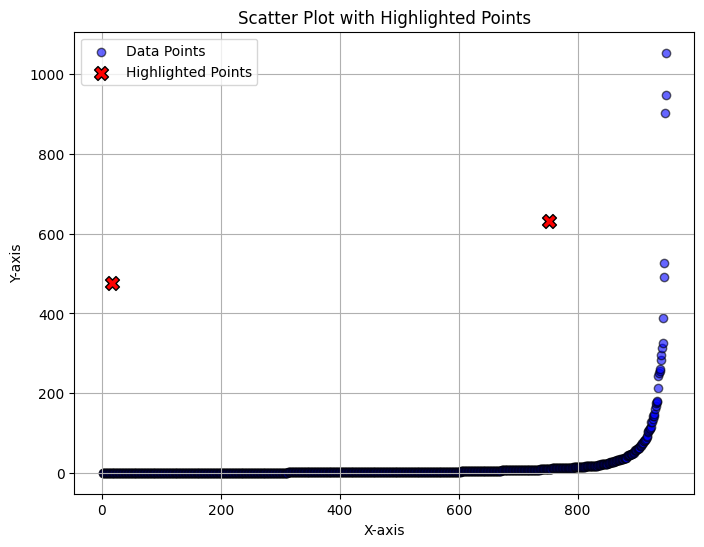

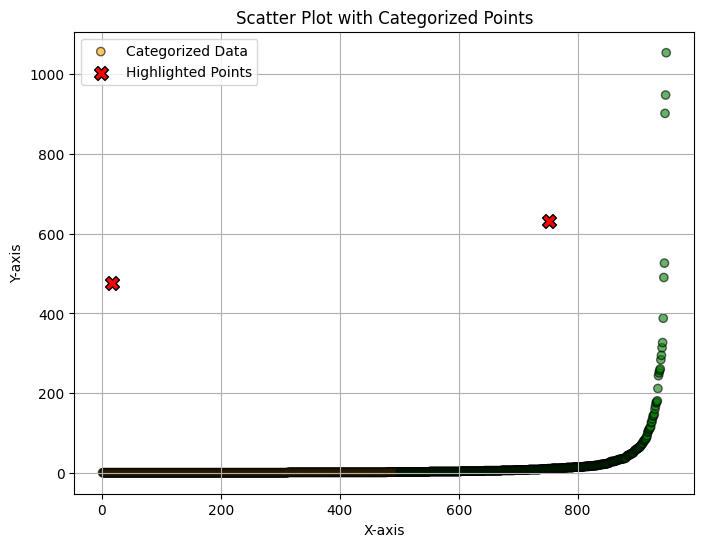


===== ĐÁNH GIÁ MÔ HÌNH K-MEAN =====
Tổng số mail bị đánh dấu là spam: 620
Tổng số mail chứa từ khóa spam: 1612
Số mail bị đánh dấu là spam và có chứa từ khóa spam: 620
Số mail bị đánh dấu là spam nhưng không chứa từ khóa spam: 0
Số mail không bị đánh dấu là spam nhưng lại chứa từ khóa spam: 992
Accuracy: 1.0


In [11]:
mbox_path = "data2.mbox" 
emails = extract_emails(mbox_path)
train_model(emails)
K_mean()

In [ ]:
với Kmean 
B1: 